In [29]:
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.stats import skew, kurtosis
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [22]:
train_df = pd.read_csv("../../data/combined/multi_class_kaggle/train.csv")
test_df = pd.read_csv("../../data/combined/multi_class_kaggle/test.csv")
train_df.head()


,timestamp,ax,ay,az,wx,wy,wz,latitude,longitude,speed,roadQuality,source_folder
0,1.577219e+09,0.340007,0.177560,9.828766,0.000761,-0.001328,0.002563,-27.717841,-51.098865,0.009128,0,PVS 1
1,1.577219e+09,0.323846,0.156611,9.771904,0.002492,0.000136,0.001365,-27.717841,-51.098865,0.009128,0,PVS 1
2,1.577219e+09,0.342999,0.206889,9.848519,0.000628,0.001468,0.000566,-27.717841,-51.098865,0.009128,0,PVS 1
3,1.577219e+09,0.344196,0.145837,9.815000,-0.002036,0.003865,0.001631,-27.717841,-51.098865,0.009128,0,PVS 1
4,1.577219e+09,0.313072,0.142246,9.843730,-0.003367,-0.001728,-0.001831,-27.717841,-51.098865,0.009128,0,PVS 1


In [23]:
test_df.head()

,timestamp,ax,ay,az,wx,wy,wz,latitude,longitude,speed,roadQuality,source_folder
0,1.577395e+09,-0.549481,0.254490,9.670964,-0.005112,-0.008083,-0.001210,-27.717691,-51.099059,0.013615,0,PVS 7
1,1.577395e+09,-0.503991,0.298783,9.532100,-0.003780,-0.007018,-0.000144,-27.717691,-51.099059,0.013615,0,PVS 7
2,1.577395e+09,-0.576416,0.446625,9.602130,0.002478,0.006298,-0.000011,-27.717691,-51.099059,0.013615,0,PVS 7
3,1.577395e+09,-0.516561,0.264666,9.459077,0.003144,0.004433,0.000655,-27.717691,-51.099059,0.013615,0,PVS 7
4,1.577395e+09,-0.554868,0.518451,9.880456,0.006340,0.012423,-0.003606,-27.717691,-51.099059,0.013615,0,PVS 7


Windowing the data by 20 rows, and placing the statistical features then using  the mode of roadQuality as the label 
* mean
* std
* rms
* skewness
* kurtosis
* max
* min
* range (max-min) 
* dom_freq 
* spec_energy


In [39]:
def extract_window_features(df, window_size=20):
    cols = ['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'speed']
    stats_list = []
    step = 0
    
    for i in range(0, len(df) - window_size + 1, step):
        window = df.iloc[i:i + window_size]
        features = {}
        
        for col in cols:
            data = window[col].values
            features[f'{col}_mean'] = np.mean(data)
            features[f'{col}_std'] = np.std(data)
            features[f'{col}_rms'] = np.sqrt(np.mean(data**2))
            features[f'{col}_skew'] = skew(data)
            features[f'{col}_kurtosis'] = kurtosis(data)
            features[f'{col}_max'] = np.max(data)
            features[f'{col}_min'] = np.min(data)
            features[f'{col}_range'] = features[f'{col}_max'] - features[f'{col}_min']
            features[f'{col}_dom_freq'] = np.argmax(np.abs(np.fft.rfft(data)))
            features[f'{col}_spec_energy'] = np.sum(np.abs(np.fft.rfft(data))**2)
            
        if 'roadQuality' in window.columns:
            features['roadQuality'] = window['roadQuality'].mode()[0]
            
        if 'label' in df.columns:
            features['label'] = window['label'].mode()[0]
        stats_list.append(features)
        
    return pd.DataFrame(stats_list)

train_stats = extract_window_features(train_df)
test_stats = extract_window_features(test_df)


ValueError: range() arg 3 must not be zero

In [25]:
train_stats.shape

(6879, 71)

fixing the Null values from calculating Kurtosis and Skewness

In [26]:
train_stats.fillna(0, inplace=True)
test_stats.fillna(0, inplace=True)
train_stats.head()

,ax_mean,ax_std,ax_rms,ax_skew,ax_kurtosis,ax_max,ax_min,ax_range,ax_dom_freq,ax_spec_energy,...,speed_std,speed_rms,speed_skew,speed_kurtosis,speed_max,speed_min,speed_range,speed_dom_freq,speed_spec_energy,roadQuality
0,0.334530,0.011324,0.334721,-0.387851,-0.749952,0.353773,0.313072,0.040701,0,44.792618,...,0.000139,0.009220,0.872872,-1.238095,0.009431,0.009128,0.000303,0,0.033998,0
1,0.334650,0.015304,0.334999,0.177381,-0.340644,0.364547,0.302896,0.061651,0,44.843922,...,0.001346,0.008461,-0.607540,-1.603049,0.009431,0.006526,0.002905,0,0.028280,0
2,0.337193,0.017772,0.337661,0.152232,-0.925877,0.366941,0.302896,0.064045,0,45.547391,...,0.001037,0.007039,1.960392,1.843137,0.009431,0.006526,0.002905,0,0.019607,0
3,0.337567,0.017610,0.338026,-0.425154,-0.750101,0.366941,0.302298,0.064643,0,45.642758,...,0.003886,0.010449,0.408248,-1.833333,0.014460,0.006526,0.007933,0,0.040654,0
4,0.330774,0.023477,0.331606,-0.787276,0.153138,0.371131,0.272370,0.098761,0,43.879345,...,0.002610,0.012135,-0.473078,-0.778541,0.014460,0.006526,0.007933,0,0.057548,0


X, Y splitting the data

In [27]:
X_train = train_stats.drop(columns=['roadQuality'])
y_train = train_stats['roadQuality']

X_test = test_stats.drop(columns=['roadQuality'])
y_test = test_stats['roadQuality']


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1370
           1       0.56      0.54      0.55        63
           2       0.66      0.90      0.76       908
           3       0.83      0.55      0.66       866

    accuracy                           0.83      3207
   macro avg       0.76      0.74      0.74      3207
weighted avg       0.85      0.83      0.82      3207



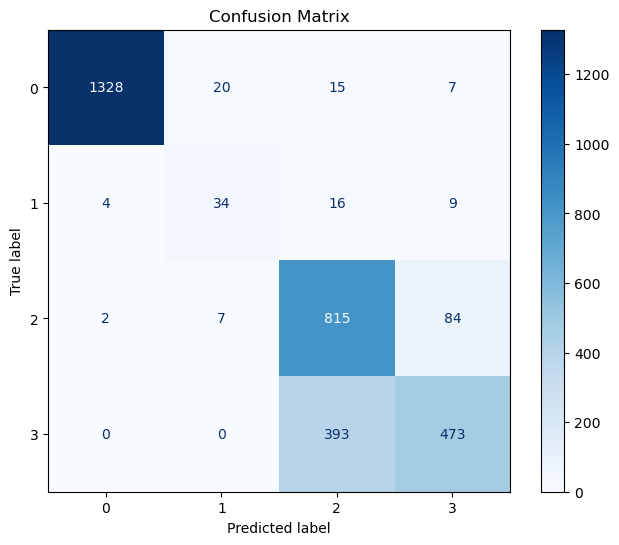

In [ ]:

# Initialize the XGBoost classifier for multi-class classification
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=10,
    
    random_state=42
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predict on test data
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()


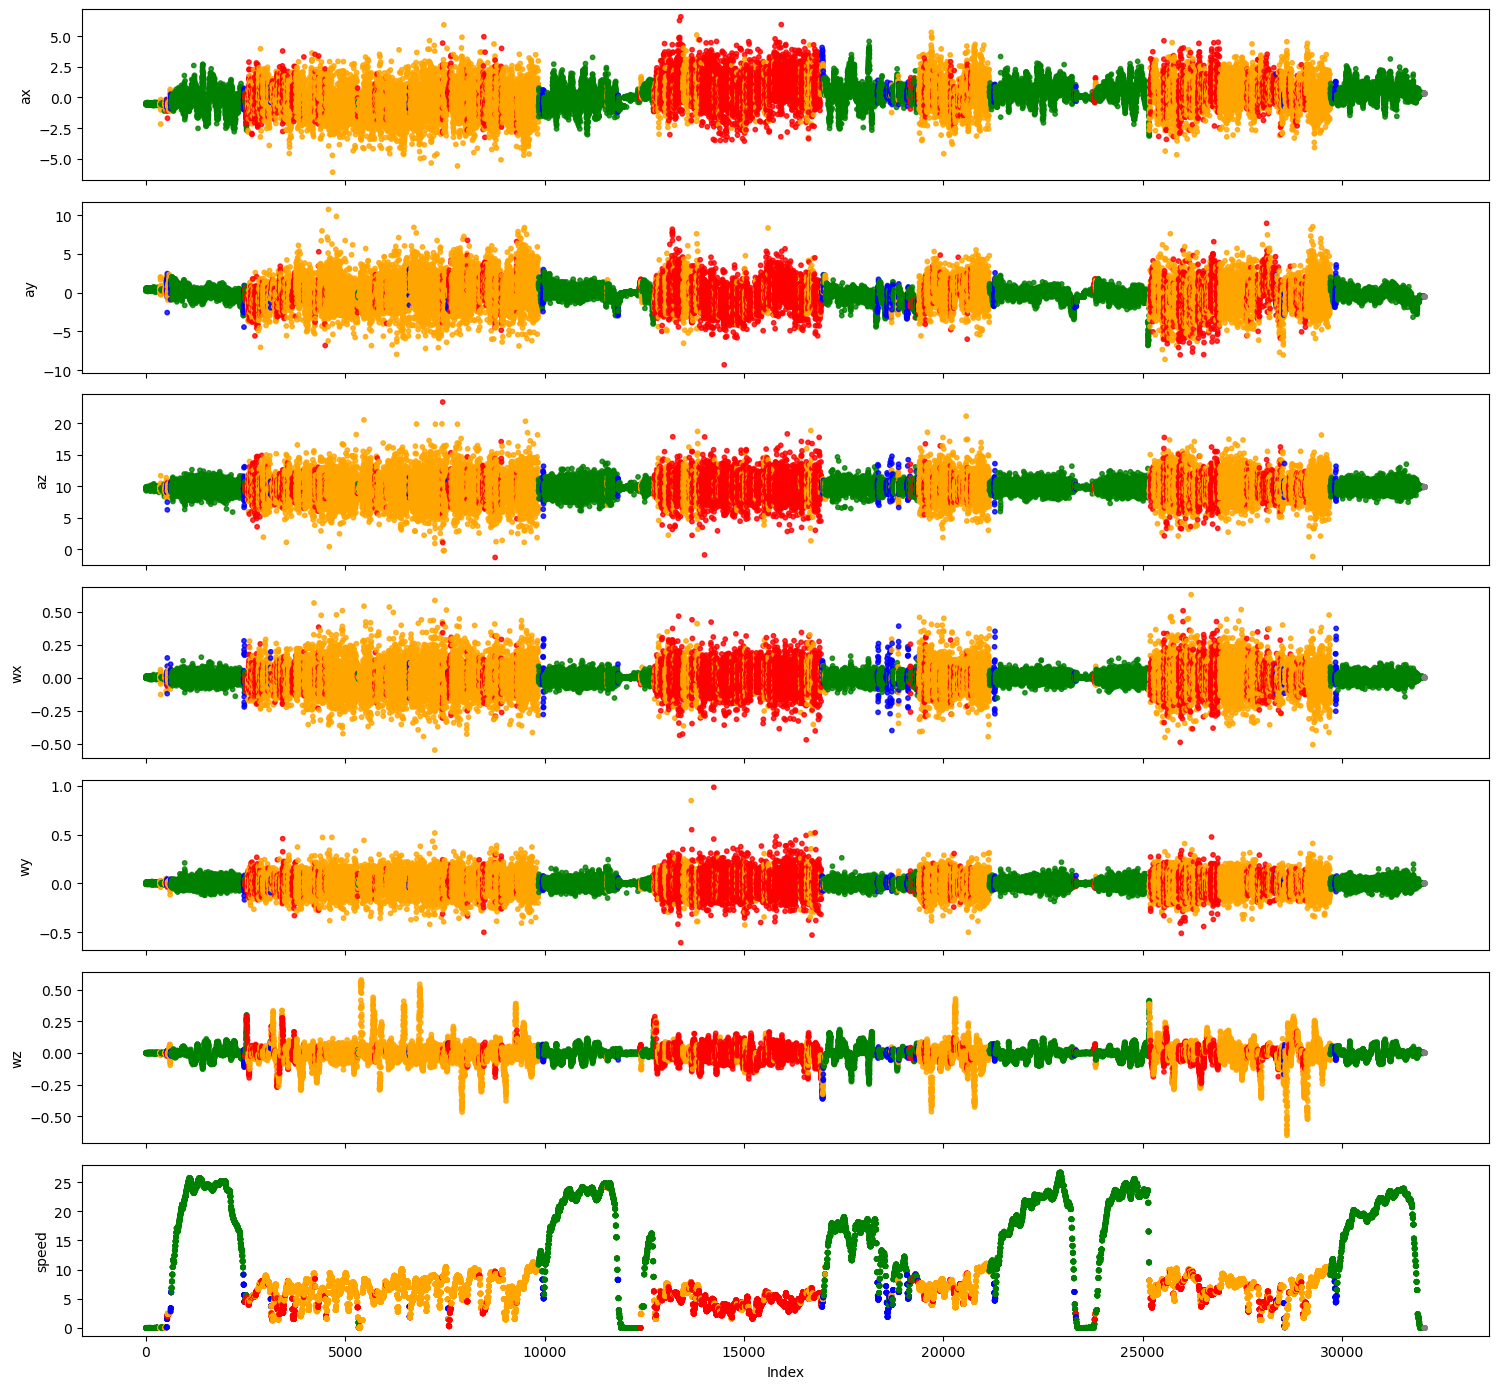

In [38]:
import matplotlib.pyplot as plt
import numpy as np

features = ['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'speed']
window_size = 20
step_size = 10

fig, axes = plt.subplots(len(features), 1, figsize=(15, 2 * len(features)), sharex=True)
label_colors = {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}

# Map each index in test_df to a color based on y_pred and step_size
point_colors = np.full(len(test_df), 'gray', dtype=object)
for j, label in enumerate(y_pred):
    start = j * step_size
    end = min(start + step_size, len(test_df))
    point_colors[start:end] = label_colors.get(label, 'gray')

for i, col in enumerate(features):
    axes[i].scatter(test_df.index, test_df[col], c=point_colors, s=10, alpha=0.8)
    axes[i].set_ylabel(col)

plt.xlabel('Index')
plt.tight_layout()
plt.show()
